# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb


# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [10]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)

In [11]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [12]:
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total
Total,2184.9350,1974.5990,1.0000,-131.8862,-210.3360,-342.2222
JASMYUSDT,387.4585,242.5534,0.1228,0.0000,-144.9051,-144.9051
ETHUSDT,250.7473,169.9046,0.0860,0.0000,-80.8428,-80.8428
BBUSDT,60.1761,35.7502,0.0181,-39.7331,-24.4259,-64.1590
BTCUSDT,601.0216,551.5223,0.2793,3.5371,-49.4994,-45.9623
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
SOLUSDT,281.2005,257.3225,0.1303,0.0000,-23.8780,-23.8780
BNBUSDT,1.1421,0.9893,0.0005,-10.6060,-0.1528,-10.7589
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,77.5651,0.0393,-10.7239,0.6961,-10.0278


In [13]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [14]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [15]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [16]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [17]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [18]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [19]:
positions

,BBUSDT,BNBUSDT,BTCUSDT,ETHUSDT,JASMYUSDT,OMUSDT,PEPEUSDT,SOLUSDT,TRXUSDT
2024-09-09,37.240261,0.020810,580.277428,163.599118,247.670579,201.904638,0.000002,241.853054,300.154099
2024-09-10,36.041216,0.020742,586.319975,165.611259,257.009397,219.007443,0.000002,242.837798,297.241866
2024-09-11,33.596560,0.021268,583.288580,162.285194,255.346320,222.440487,0.000002,237.090475,297.824313
2024-09-12,34.946941,0.021845,591.369046,163.755818,257.137326,241.790376,0.000002,243.589784,295.106229
2024-09-13,38.264689,0.022323,615.434659,169.124532,270.058157,234.487353,0.000002,248.907400,289.281764
2024-09-14,38.730337,0.022198,610.297696,167.640734,262.510345,228.287067,0.000002,245.541367,286.369532
2024-09-15,36.506864,0.022202,601.538601,160.589920,252.276024,223.210322,0.000002,235.210510,289.281764
2024-09-16,37.729192,0.021412,592.199860,159.174072,245.495786,220.235016,0.000002,235.389554,289.087615
2024-09-17,40.523085,0.021914,613.562761,162.371864,252.531882,218.508091,0.000002,235.514885,291.223252
2024-09-18,41.629001,0.022447,546.624084,164.656497,260.335552,322.801671,0.000002,240.528126,290.446657


In [20]:
positions=positions.sort_index()

In [21]:
positions.index=pd.to_datetime(positions.index)

In [22]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [23]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [24]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

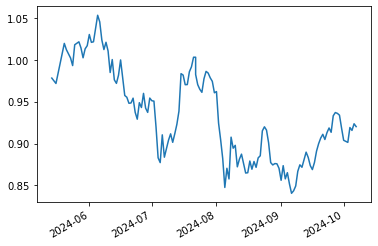

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'FTTUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT',
       'XRPUSDT'],
      dtype='object')

In [35]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9406
OMUSDT,0.0210
TRXUSDT,0.0169
BNBUSDT,0.0157
PEPEUSDT,0.0044
SUIUSDT,0.0014
FDUSDUSDT,0.0000
JASMYUSDT,0.0000
WBTCUSDT,0.0000
BTCUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.484264
BTCUSDT,0.400000
PEPEUSDT,0.066331
BNBUSDT,0.036206
SUIUSDT,0.013198


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.734116
OMUSDT,0.265884


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,638.991728,0.323606,0.265884,0.057722
BTCUSDT,551.522283,0.279309,0.000000,0.000000
SOLUSDT,257.322482,0.130316,0.000000,0.000000
JASMYUSDT,242.553418,0.122837,0.000000,0.000000
ETHUSDT,169.904565,0.086045,0.000000,0.000000
TRXUSDT,77.565058,0.039281,0.734116,-0.694835
BBUSDT,35.750185,0.018105,0.000000,0.000000
BNBUSDT,0.989305,0.000501,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,638.991728,0.323606,0.484264,-0.160658
BTCUSDT,551.522283,0.279309,0.400000,-0.120692
SOLUSDT,257.322482,0.130316,0.000000,0.000000
JASMYUSDT,242.553418,0.122837,0.000000,0.000000
ETHUSDT,169.904565,0.086045,0.000000,0.000000
TRXUSDT,77.565058,0.039281,0.000000,0.000000
BBUSDT,35.750185,0.018105,0.000000,0.000000
BNBUSDT,0.989305,0.000501,0.036206,-0.035705
PEPEUSDT,0.000002,0.000000,0.066331,-0.066331
SUIUSDT,0.000000,0.000000,0.013198,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

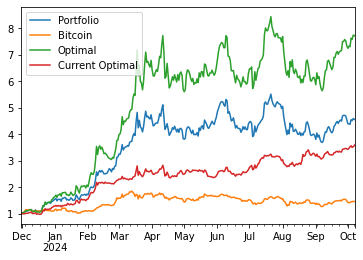

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

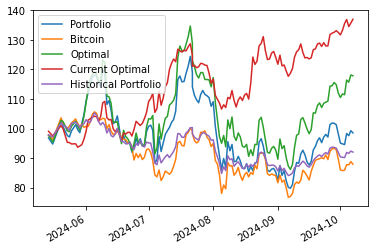

In [46]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-28,101.768535,93.251712,115.585833,132.582112,93.595109
2024-09-29,101.294401,92.888537,114.839672,133.127438,93.379558
2024-09-30,98.104195,89.610942,111.986792,132.515919,91.840967
2024-10-01,95.050769,85.969490,110.506242,131.696777,90.386098
2024-10-02,94.813349,85.747939,111.730820,133.278659,90.261509
2024-10-03,94.544706,85.894047,111.439372,135.527598,90.135937
2024-10-04,98.308120,87.758707,116.394858,136.905308,91.907783
2024-10-05,97.570839,87.719120,115.695822,134.516622,91.567253
2024-10-06,99.255893,88.789524,118.121651,135.695782,92.355012
2024-10-07,98.524423,87.943245,117.855972,136.990721,92.014237


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.723913
dtype: float64

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.536093
dtype: float64

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.607485
Bitcoin            0.437871
Optimal            0.725041
Current Optimal    0.422184
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20189245284730614

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.043631,0.036206,0.006499,0.010289,0.000594,0.009695
BTCUSDT,0.186917,0.400000,0.047775,0.151762,0.058356,0.093405
OMUSDT,10.887519,0.484264,0.925654,0.779260,0.684346,0.094914
PEPEUSDT,0.154605,0.066331,0.017984,0.053416,0.013751,0.039665
SUIUSDT,0.012457,0.013198,0.002088,0.005273,0.000302,0.004972


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.157612,0.265884,0.317694,0.5019,0.439622,0.062278
TRXUSDT,0.175417,0.734116,0.682306,0.4981,0.435823,0.062278


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.189691,0.32,0.460463,0.414638,0.245719,0.168919
BTCUSDT,-0.015757,0.28,0.238721,0.179215,0.045211,0.134004
SOLUSDT,-0.018307,0.13,0.100905,0.129540,0.025479,0.104061
JASMYUSDT,-0.024888,0.12,0.085925,0.167227,0.046284,0.120944
ETHUSDT,-0.021235,0.09,0.062124,0.069697,0.008153,0.061544
TRXUSDT,0.009558,0.04,0.044771,0.006164,0.000499,0.005665
BBUSDT,-0.012151,0.02,0.007091,0.033518,0.002711,0.030806


# Value At Risk

## Historical

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.059782915028680134, -0.08590040163879013)

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04981775180647042, -0.06798533236201329)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.008628
BTCUSDT     -0.015666
SOLUSDT     -0.008841
JASMYUSDT   -0.005774
ETHUSDT     -0.007823
TRXUSDT     -0.000926
BBUSDT      -0.002220
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049878
Name: 2024-08-27 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.029217
BTCUSDT     -0.011814
SOLUSDT     -0.009519
JASMYUSDT   -0.010030
ETHUSDT     -0.005065
TRXUSDT     -0.000555
BBUSDT      -0.001786
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067985
dtype: float64

## Parametric

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07512584277806095, -0.09629055929631983)

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.055547797041058444, -0.07119691769133764)

## Multivariate

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06848310770708321, -0.08795614201571458)

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05377140263564978, -0.06796722357541662)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.021937
BTCUSDT     -0.009817
SOLUSDT     -0.007024
JASMYUSDT   -0.009517
ETHUSDT     -0.003933
TRXUSDT     -0.000166
BBUSDT      -0.001756
Portfolio   -0.054151
dtype: float64

## Copulas

### Gaussian Copula

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06887173008886165, -0.0876220730891725)

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05473660053269126, -0.06908315344195187)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.023048
BTCUSDT     -0.009253
SOLUSDT     -0.006860
JASMYUSDT   -0.009157
ETHUSDT     -0.003703
TRXUSDT     -0.000273
BBUSDT      -0.001774
Portfolio   -0.054068
dtype: float64

### Student Copula

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06667784747647483, -0.0852547209520703)

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05563835837527677, -0.07060972248724158)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021155
BTCUSDT     -0.009502
SOLUSDT     -0.007440
JASMYUSDT   -0.010703
ETHUSDT     -0.004211
TRXUSDT     -0.000266
BBUSDT      -0.002035
Portfolio   -0.055313
dtype: float64

### Gumbel Copula

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13865948212820473, -0.1980112337115866)

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06847726599629074, -0.09695714000193353)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.046439
BTCUSDT     -0.008091
SOLUSDT     -0.004644
JASMYUSDT   -0.010653
ETHUSDT     -0.001247
TRXUSDT      0.000081
BBUSDT      -0.000256
Portfolio   -0.071249
dtype: float64

### Monte Carlo

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07648570342262126, -0.09573177093948596)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05644238324594389, -0.0707185187586986)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.023443
BTCUSDT     -0.010222
SOLUSDT     -0.006846
JASMYUSDT   -0.009862
ETHUSDT     -0.003972
TRXUSDT     -0.000279
BBUSDT      -0.001947
Portfolio   -0.056571
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.060674,-0.108656,-0.090936,-0.024722
2024-01-15,-0.060674,-0.108653,-0.090747,0.017497
2024-01-16,-0.060674,-0.109187,-0.090365,0.059802
2024-01-17,-0.060674,-0.111559,-0.093611,-0.035338
2024-01-18,-0.060674,-0.113727,-0.098209,-0.035126
...,...,...,...,...
2024-10-04,-0.039867,-0.063103,-0.054564,0.044468
2024-10-05,-0.028968,-0.059332,-0.050590,-0.006006
2024-10-06,-0.023392,-0.056949,-0.046593,0.020967
2024-10-07,-0.023392,-0.056253,-0.045718,-0.002249


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031450,-0.084551,-0.079039,-0.016978
2024-05-29,-0.029067,-0.081734,-0.073451,-0.010002
2024-05-30,-0.029067,-0.070693,-0.066849,0.033529
2024-05-31,-0.029067,-0.069917,-0.059578,0.028292
2024-06-01,-0.029067,-0.071489,-0.062495,0.043198
...,...,...,...,...
2024-10-04,-0.031443,-0.050786,-0.046627,0.039806
2024-10-05,-0.031443,-0.049933,-0.048752,-0.007500
2024-10-06,-0.031443,-0.050554,-0.047834,0.017270
2024-10-07,-0.031443,-0.049494,-0.046238,-0.007370


<AxesSubplot:>

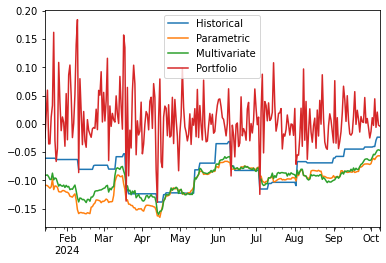

In [80]:
var_data.plot()

<AxesSubplot:>

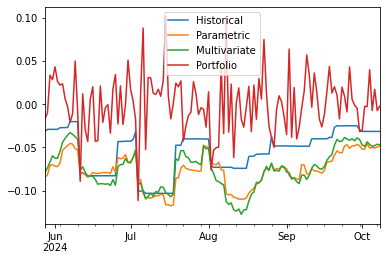

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022305,0.011152,0.011152
Kupiec Stat,5.428472,12.319414,12.319414
P-value,0.019811,0.000448,0.000448


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.059701,0.022388,0.022388
Kupiec Stat,0.250665,2.685543,2.685543
P-value,0.616607,0.101263,0.101263


## Principal Component Analysis

### Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78380505, 0.06859286, 0.05599113, 0.04756294, 0.04404802])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.015021
ADAUSDT      0.015291
ALGOUSDT     0.016897
APTUSDT      0.016083
ARBUSDT      0.016657
               ...   
WBETHUSDT    0.012773
WBTCUSDT     0.010557
WLDUSDT      0.023054
XLMUSDT      0.010181
XRPUSDT      0.009803
Name: PC1, Length: 61, dtype: float64

<AxesSubplot:>

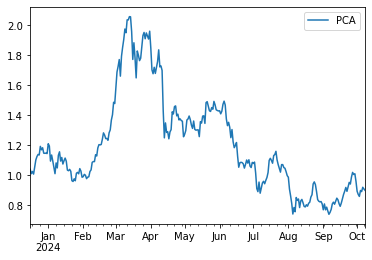

In [86]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

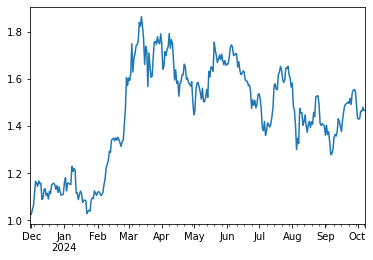

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.342790
ALGOUSDT     0.349458
WBETHUSDT    0.358031
ETHUSDT      0.358141
               ...   
PEPEUSDT     1.004864
FLOKIUSDT    1.011218
FTTUSDT      1.035561
WLDUSDT      1.049733
OMUSDT       1.320512
Length: 62, dtype: float64

<AxesSubplot:>

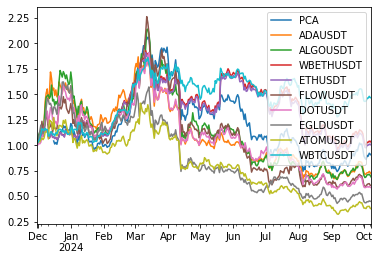

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

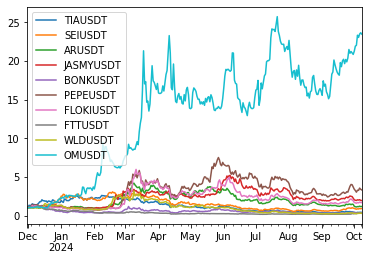

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67212886, 0.13803544, 0.08806417, 0.06988065, 0.03189088])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.096230
BTCUSDT      0.064388
SOLUSDT      0.104427
JASMYUSDT    0.155310
ETHUSDT      0.086503
TRXUSDT      0.014817
BBUSDT       0.243036
BNBUSDT      0.068218
PEPEUSDT     0.167071
Name: PC1, dtype: float64

<AxesSubplot:>

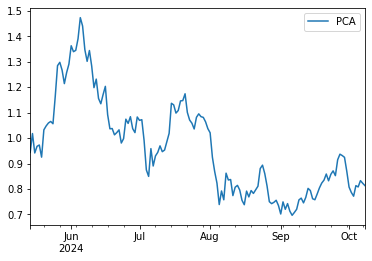

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

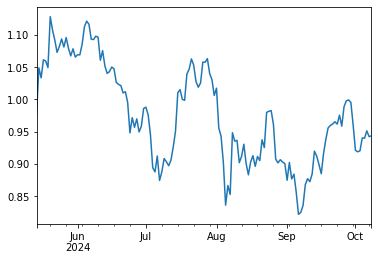

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.337361
SOLUSDT      0.345664
BTCUSDT      0.371645
BNBUSDT      0.374386
JASMYUSDT    0.428485
PEPEUSDT     0.479473
OMUSDT       0.555189
TRXUSDT      0.557307
BBUSDT       0.631732
dtype: float64

<AxesSubplot:>

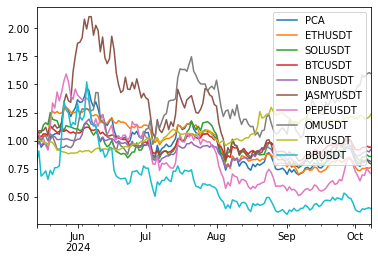

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.954637
BBUSDT       1.671399
JASMYUSDT    1.301014
SOLUSDT      1.169890
BTCUSDT      1.000000
OMUSDT       0.977380
ETHUSDT      0.957451
BNBUSDT      0.678395
TRXUSDT      0.278775
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.921989
BBUSDT       2.641277
JASMYUSDT    2.133860
SOLUSDT      1.509708
ETHUSDT      1.038637
BTCUSDT      1.000000
BNBUSDT      0.979818
OMUSDT       0.372155
TRXUSDT      0.280845
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [99]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
